In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
from math import sqrt
import itertools 


color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [171]:
url = 'https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv'

df = pd.read_csv(url)

df = df.rename(columns={'Month' : 'month', '#Passengers' : 'passengers'})

df['month'] = pd.to_datetime(df['month'])
df = df.set_index('month')
df

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [172]:
### Data Preprocessing

In [173]:
df.tail()

,passengers
month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


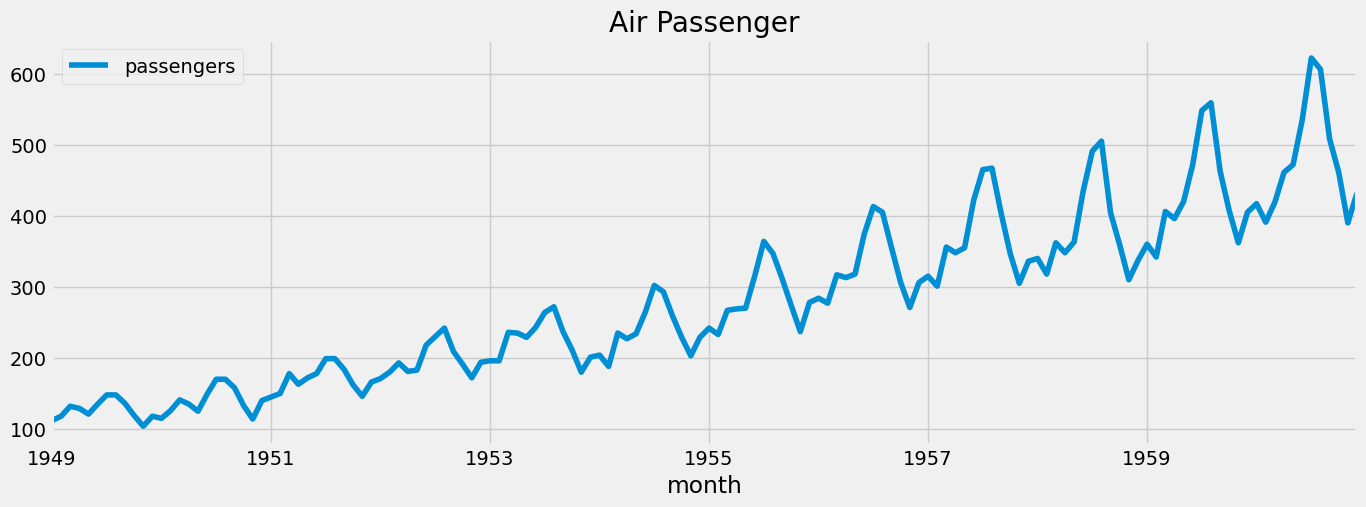

In [174]:
df.plot(style='',
        figsize=(15, 5),
        color=color_pal[0],
        title='Air Passenger')
plt.show()

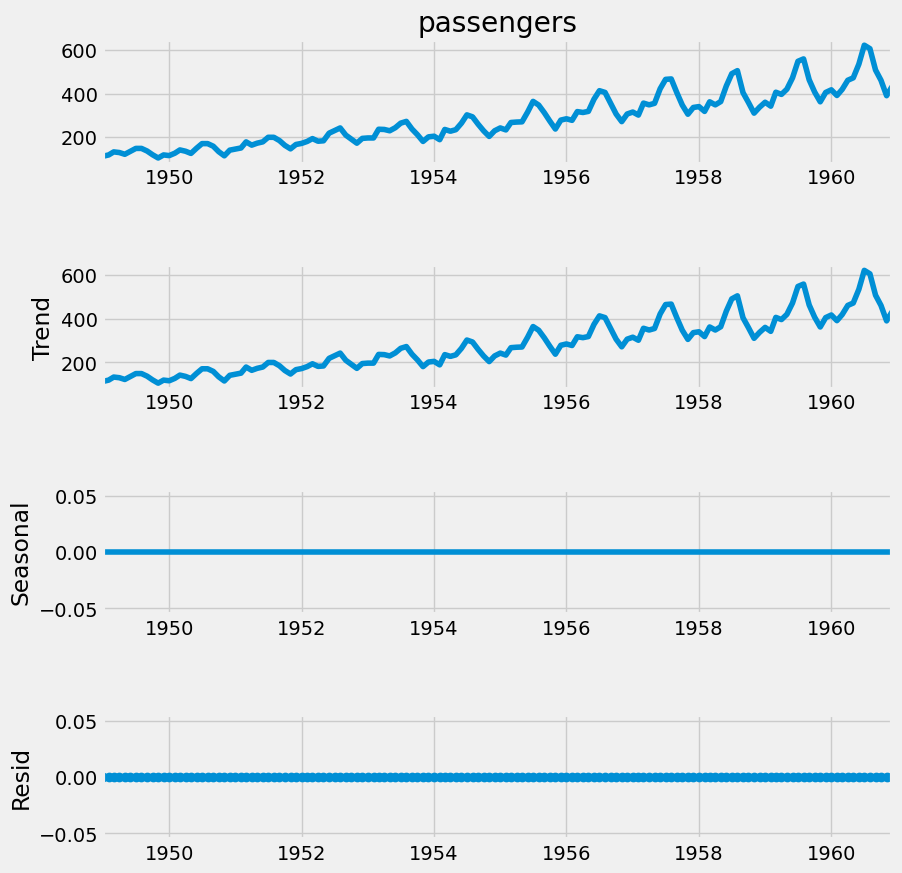

In [175]:
#decomposition

decomposition = sm.tsa.seasonal_decompose(df['passengers'], model = 'additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

In [176]:
df.isna().sum()

passengers    0
dtype: int64

In [177]:
###log Transformation

df_log = np.log(df['passengers'])

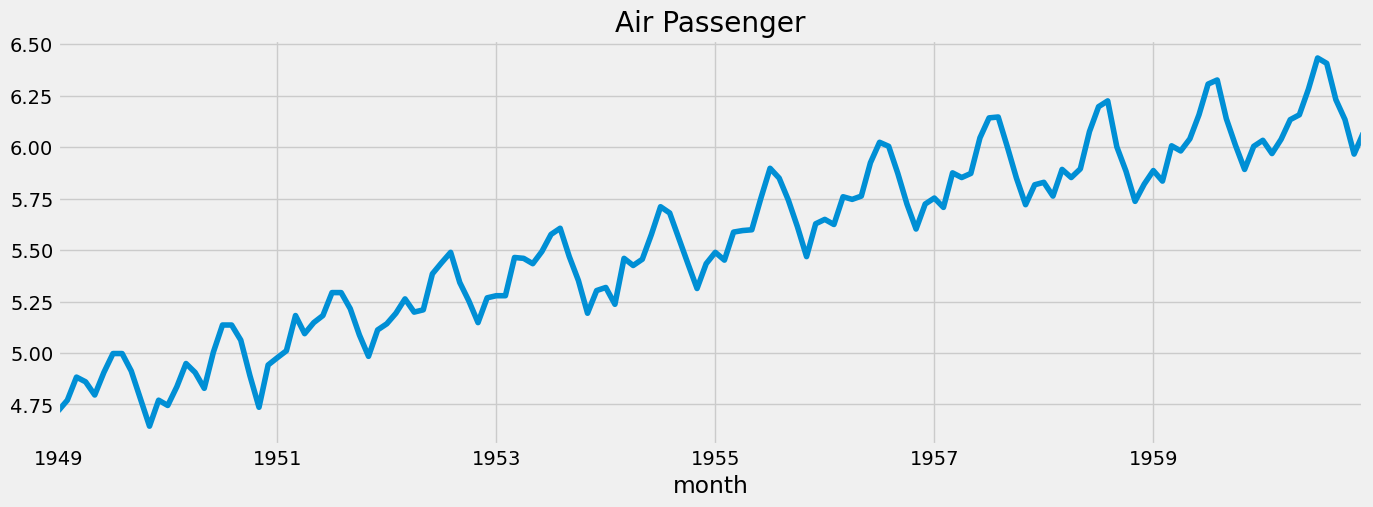

In [178]:
df_log.plot(style='',
        figsize=(15, 5),
        color=color_pal[0],
        title='Air Passenger')
plt.show()

In [179]:
### Identify Model to tentatively Entertainted

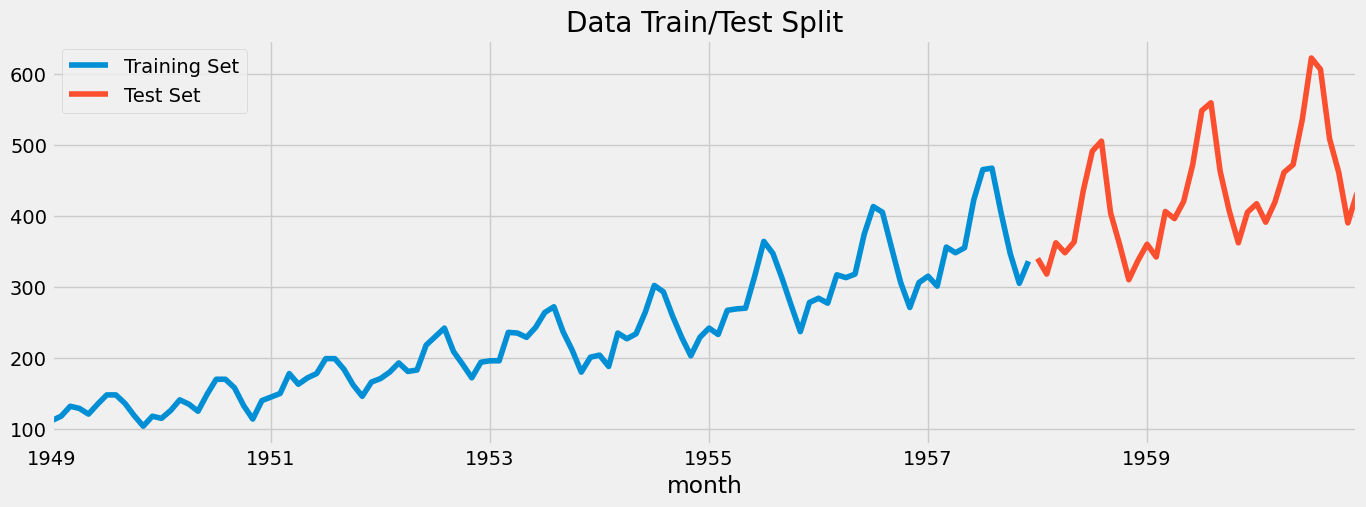

In [202]:
# Split dataset into Training and Test

train = df.loc[df_log.index < '01-01-1958']
test = df.loc[df_log.index >= '01-01-1958']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


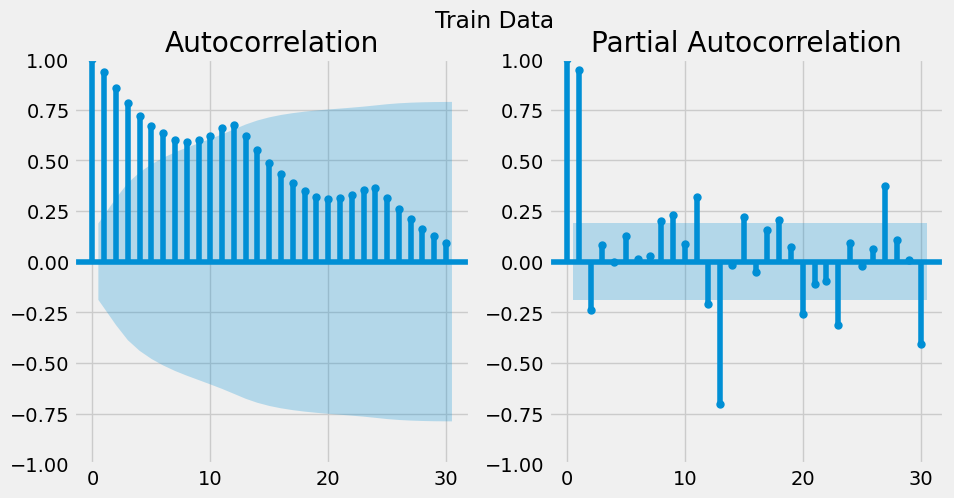

In [203]:
## ACF, PACF plot : Train dataset

fig, ax =plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Train Data')

sm.graphics.tsa.plot_acf(train.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train.values.squeeze(), lags=30, ax=ax[1]);


In [204]:
## ADF test
 # result : Non-stationary

adf_test = adfuller(train)
print(f'p-value: {adf_test[1]}')

p-value: 0.9942931644042373


In [205]:
### Differencing

train_diff = train.copy()
train_diff = train_diff.diff().dropna()

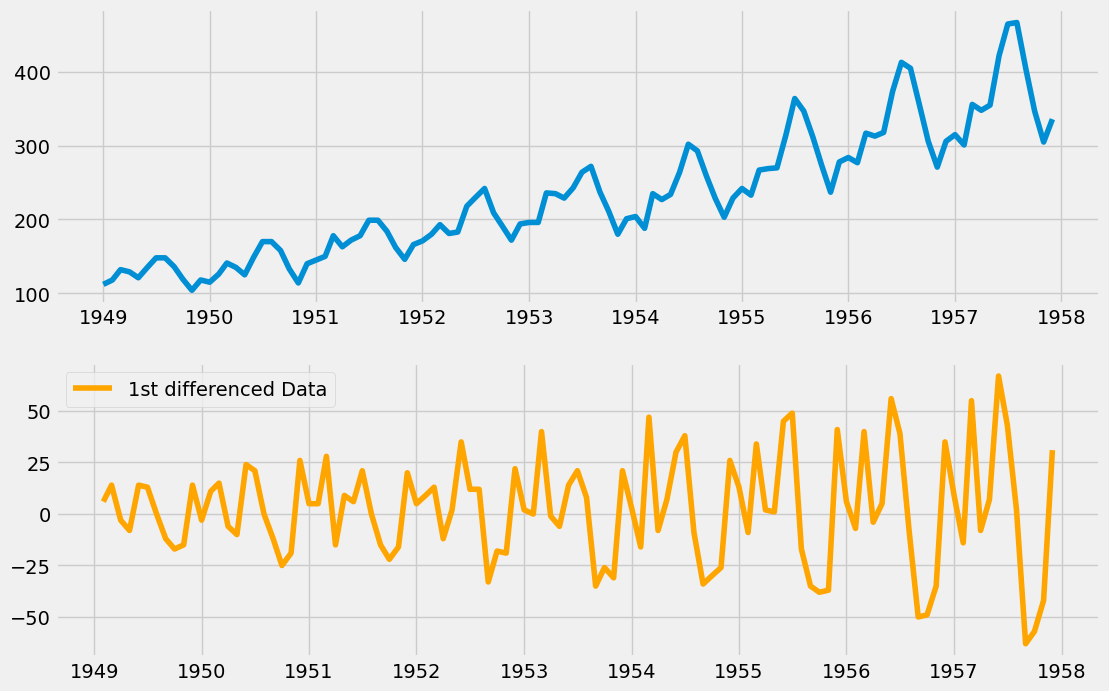

In [206]:
 ## Differenced data plot

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train)
plt.subplot(212)
plt.plot(train_diff, 'orange')
plt.legend(['1st differenced Data'])
plt.show()

C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


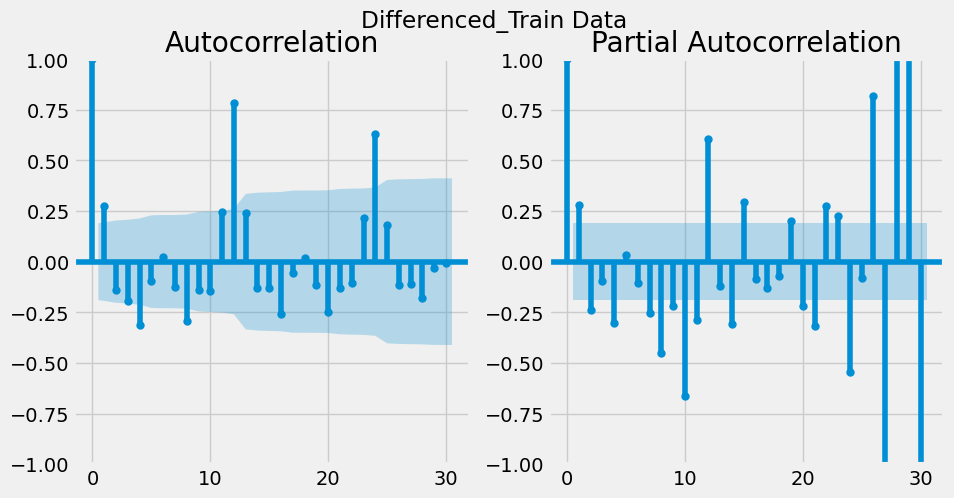

In [207]:
 ## ACF, PACF plot : differenced train data
    
fig, ax =plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Differenced_Train Data')

sm.graphics.tsa.plot_acf(train_diff.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_diff.values.squeeze(), lags=30, ax=ax[1]);

In [186]:
### Identification ARIMA model parameters 

In [208]:
  ## Fit ARIMA Model

model = ARIMA(train, order=(1,1,0))

model_fit = model.fit()

model_fit.summary()


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passengers   No. Observations:                  108
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -495.410
Date:                Wed, 01 Mar 2023   AIC                            994.820
Time:                        23:08:54   BIC                           1000.166
Sample:                    01-01-1949   HQIC                           996.987
                         - 12-01-1957                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2802      0.091      3.095      0.002       0.103       0.458
sigma2       614.8338     86.024      7.147      0.000     446.230     783.438
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):                 2.21
Prob(Q):                              0.49   Prob(JB):                         0.33
Heteroskedasticity (H):               5.24   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
### Diagnosis check

In [209]:
  ## Search Parameters

print('Paramater combinations for ARIMA model')
p = range(0,3)
d = range(1,2)
q = range(0,3)

pdq = list(itertools.product(p,d,q))

aic = []

for i in pdq :
    model = ARIMA(train.values, order = (i))
    model_fit = model.fit()
    print(f'ARIMA : {i} >> AIC : {round(model_fit.aic, 2)}')
    aic.append(round(model_fit.aic,2))

Paramater combinations for ARIMA model
ARIMA : (0, 1, 0) >> AIC : 1001.53
ARIMA : (0, 1, 1) >> AIC : 990.1
ARIMA : (0, 1, 2) >> AIC : 987.95
ARIMA : (1, 1, 0) >> AIC : 994.82
ARIMA : (1, 1, 1) >> AIC : 987.28
ARIMA : (1, 1, 2) >> AIC : 982.14
ARIMA : (2, 1, 0) >> AIC : 990.47
ARIMA : (2, 1, 1) >> AIC : 981.18
ARIMA : (2, 1, 2) >> AIC : 983.83


In [210]:
  ## Search Otimal Parameter

optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal 

[((2, 1, 1), 981.18)]

In [211]:
model_opt = ARIMA(train.values, order = optimal[0][0])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -486.590
Date:                Wed, 01 Mar 2023   AIC                            981.181
Time:                        23:09:03   BIC                            991.872
Sample:                             0   HQIC                           985.515
                                - 108                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0506      0.107      9.849      0.000       0.842       1.260
ar.L2         -0.4606      0.112     -4.121      0.000      -0.680      -0.242
ma.L1         -0.8145      0.104     -7.800      0.000      -1.019      -0.610
sigma2       518.4064     70.145      7.390      0.000     380.924     655.888
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 7.89
Prob(Q):                              0.51   Prob(JB):                         0.02
Heteroskedasticity (H):               5.03   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [212]:
### Forecast : ARIMA

pred = model_opt_fit.forecast(len(test))
pred_value = pred[0]
pred_ub = pred[2][:,0]
pred_lb = pred[2][:,1]
pred_index = list(test.index)

rmse = sqrt(mean_squared_error(test, pred))

IndexError: invalid index to scalar variable.

ValueError: x and y must have same first dimension, but have shapes (36,) and (1,)

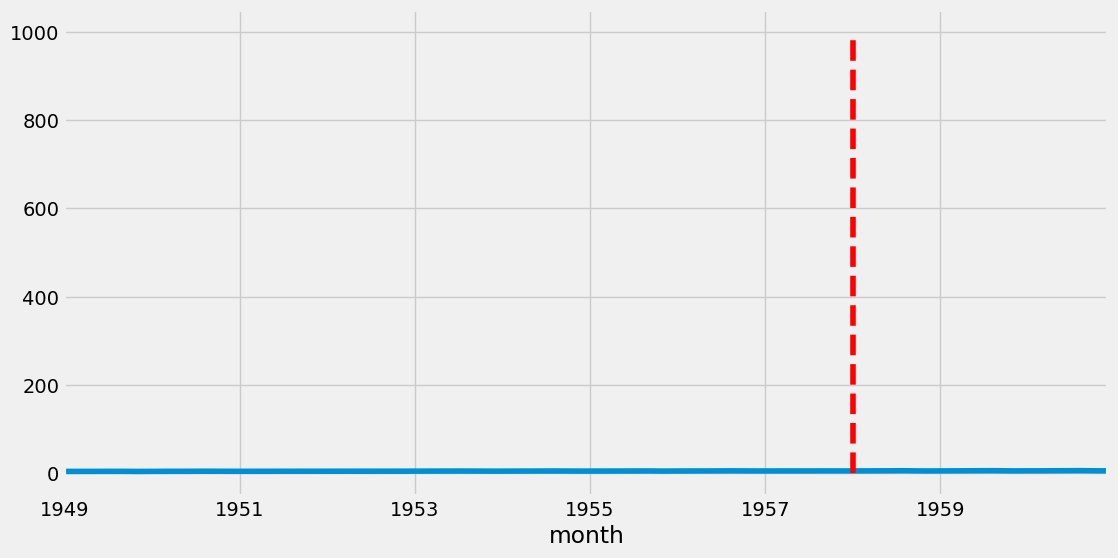

In [213]:
fig, ax =plt.subplots(figsize =(12, 6))
df_log.plot(ax=ax)
ax.vlines('01-01-1958' , 0, 1000, linestyle = '--', color = 'r', label = 'Split line') ;
ax.plot(pred_index, pred_value, label = 'prediction')
ax.fill_betweeen(predict_index, pred_lb, pred_ub, color = 'k', alpha = 0.1, label = '95% Prediction Interval')
ax.legend(loc = 'upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Predicted Results (RMSE: {round(rmse,2)})')
plt.show()

In [ ]:
### SARIMA

In [214]:
  ## Search parameter
    
print('Paramater combinations for SARIMA model')

p = range(0,3)
d = range(1,2)
q = range(0,3)

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

aic = []
params = []

for i in pdq :
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train.values, order = (i), seasonal_order = (j))
            model_fit = model.fit()
            print(f'SARIMA : {i}{j} >> AIC : {round(model_fit.aic, 2)}')
            aic.append(round(model_fit.aic,2))
            params.append((i, j))
        except:
            continue

Paramater combinations for SARIMA model
SARIMA : (0, 1, 0)(0, 1, 0, 12) >> AIC : 707.73
SARIMA : (0, 1, 0)(0, 1, 1, 12) >> AIC : 706.72


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


SARIMA : (0, 1, 0)(0, 1, 2, 12) >> AIC : 708.58
SARIMA : (0, 1, 0)(1, 1, 0, 12) >> AIC : 706.7
SARIMA : (0, 1, 0)(1, 1, 1, 12) >> AIC : 708.65
SARIMA : (0, 1, 0)(1, 1, 2, 12) >> AIC : 705.64
SARIMA : (0, 1, 0)(2, 1, 0, 12) >> AIC : 708.6


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (0, 1, 0)(2, 1, 1, 12) >> AIC : 710.12


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (0, 1, 0)(2, 1, 2, 12) >> AIC : 705.57
SARIMA : (0, 1, 1)(0, 1, 0, 12) >> AIC : 704.38
SARIMA : (0, 1, 1)(0, 1, 1, 12) >> AIC : 704.8
SARIMA : (0, 1, 1)(0, 1, 2, 12) >> AIC : 705.77
SARIMA : (0, 1, 1)(1, 1, 0, 12) >> AIC : 704.53
SARIMA : (0, 1, 1)(1, 1, 1, 12) >> AIC : 706.38
SARIMA : (0, 1, 1)(1, 1, 2, 12) >> AIC : 700.76
SARIMA : (0, 1, 1)(2, 1, 0, 12) >> AIC : 706.1
SARIMA : (0, 1, 1)(2, 1, 1, 12) >> AIC : 702.32


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (0, 1, 1)(2, 1, 2, 12) >> AIC : 701.99
SARIMA : (0, 1, 2)(0, 1, 0, 12) >> AIC : 706.37
SARIMA : (0, 1, 2)(0, 1, 1, 12) >> AIC : 706.78
SARIMA : (0, 1, 2)(0, 1, 2, 12) >> AIC : 707.75
SARIMA : (0, 1, 2)(1, 1, 0, 12) >> AIC : 706.5
SARIMA : (0, 1, 2)(1, 1, 1, 12) >> AIC : 708.35


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (0, 1, 2)(1, 1, 2, 12) >> AIC : 702.75
SARIMA : (0, 1, 2)(2, 1, 0, 12) >> AIC : 708.08
SARIMA : (0, 1, 2)(2, 1, 1, 12) >> AIC : 704.32


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (0, 1, 2)(2, 1, 2, 12) >> AIC : 703.97
SARIMA : (1, 1, 0)(0, 1, 0, 12) >> AIC : 704.0
SARIMA : (1, 1, 0)(0, 1, 1, 12) >> AIC : 704.47
SARIMA : (1, 1, 0)(0, 1, 2, 12) >> AIC : 705.34
SARIMA : (1, 1, 0)(1, 1, 0, 12) >> AIC : 704.19
SARIMA : (1, 1, 0)(1, 1, 1, 12) >> AIC : 705.99
SARIMA : (1, 1, 0)(1, 1, 2, 12) >> AIC : 700.58
SARIMA : (1, 1, 0)(2, 1, 0, 12) >> AIC : 705.65
SARIMA : (1, 1, 0)(2, 1, 1, 12) >> AIC : 702.02


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (1, 1, 0)(2, 1, 2, 12) >> AIC : 701.78
SARIMA : (1, 1, 1)(0, 1, 0, 12) >> AIC : 705.08
SARIMA : (1, 1, 1)(0, 1, 1, 12) >> AIC : 705.63
SARIMA : (1, 1, 1)(0, 1, 2, 12) >> AIC : 706.61
SARIMA : (1, 1, 1)(1, 1, 0, 12) >> AIC : 705.37
SARIMA : (1, 1, 1)(1, 1, 1, 12) >> AIC : 707.16


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (1, 1, 1)(1, 1, 2, 12) >> AIC : 702.43
SARIMA : (1, 1, 1)(2, 1, 0, 12) >> AIC : 706.84
SARIMA : (1, 1, 1)(2, 1, 1, 12) >> AIC : 703.78


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (1, 1, 1)(2, 1, 2, 12) >> AIC : 703.47
SARIMA : (1, 1, 2)(0, 1, 0, 12) >> AIC : 707.07
SARIMA : (1, 1, 2)(0, 1, 1, 12) >> AIC : 707.63
SARIMA : (1, 1, 2)(0, 1, 2, 12) >> AIC : 708.59
SARIMA : (1, 1, 2)(1, 1, 0, 12) >> AIC : 707.37
SARIMA : (1, 1, 2)(1, 1, 1, 12) >> AIC : 709.16


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (1, 1, 2)(1, 1, 2, 12) >> AIC : 704.21
SARIMA : (1, 1, 2)(2, 1, 0, 12) >> AIC : 708.82
SARIMA : (1, 1, 2)(2, 1, 1, 12) >> AIC : 705.52
SARIMA : (1, 1, 2)(2, 1, 2, 12) >> AIC : 705.37
SARIMA : (2, 1, 0)(0, 1, 0, 12) >> AIC : 705.69
SARIMA : (2, 1, 0)(0, 1, 1, 12) >> AIC : 706.15
SARIMA : (2, 1, 0)(0, 1, 2, 12) >> AIC : 707.05
SARIMA : (2, 1, 0)(1, 1, 0, 12) >> AIC : 705.86
SARIMA : (2, 1, 0)(1, 1, 1, 12) >> AIC : 707.66
SARIMA : (2, 1, 0)(1, 1, 2, 12) >> AIC : 702.53
SARIMA : (2, 1, 0)(2, 1, 0, 12) >> AIC : 707.33
SARIMA : (2, 1, 0)(2, 1, 1, 12) >> AIC : 703.94


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA : (2, 1, 0)(2, 1, 2, 12) >> AIC : 703.68
SARIMA : (2, 1, 1)(0, 1, 0, 12) >> AIC : 707.08
SARIMA : (2, 1, 1)(0, 1, 1, 12) >> AIC : 707.63
SARIMA : (2, 1, 1)(0, 1, 2, 12) >> AIC : 708.6
SARIMA : (2, 1, 1)(1, 1, 0, 12) >> AIC : 707.37
SARIMA : (2, 1, 1)(1, 1, 1, 12) >> AIC : 709.16
SARIMA : (2, 1, 1)(1, 1, 2, 12) >> AIC : 700.8
SARIMA : (2, 1, 1)(2, 1, 0, 12) >> AIC : 708.83
SARIMA : (2, 1, 1)(2, 1, 1, 12) >> AIC : 702.44


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 1)(2, 1, 2, 12) >> AIC : 702.32
SARIMA : (2, 1, 2)(0, 1, 0, 12) >> AIC : 704.29
SARIMA : (2, 1, 2)(0, 1, 1, 12) >> AIC : 705.02
SARIMA : (2, 1, 2)(0, 1, 2, 12) >> AIC : 706.29
SARIMA : (2, 1, 2)(1, 1, 0, 12) >> AIC : 704.82
SARIMA : (2, 1, 2)(1, 1, 1, 12) >> AIC : 706.67


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 2)(1, 1, 2, 12) >> AIC : 701.79
SARIMA : (2, 1, 2)(2, 1, 0, 12) >> AIC : 706.46


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 2)(2, 1, 1, 12) >> AIC : 703.3
SARIMA : (2, 1, 2)(2, 1, 2, 12) >> AIC : 702.39


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [216]:
##Search optimal parameter
optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal 

[(((1, 1, 0), (1, 1, 2, 12)), 700.58)]

In [217]:
model_opt = SARIMAX(train.values, order = optimal[0][0][0], seasonal_order = optimal[0][0][1])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2], 12)   Log Likelihood                -345.288
Date:                                 Wed, 01 Mar 2023   AIC                            700.577
Time:                                         23:11:42   BIC                            713.346
Sample:                                              0   HQIC                           705.736
                                                 - 108                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2812      0.094     -2.984      0.003      -0.466      -0.097
ar.S.L12       0.9991      0.216      4.617      0.000       0.575       1.423
ma.S.L12      -1.3675      3.528     -0.388      0.698      -8.283       5.548
ma.S.L24       0.3872      1.247      0.310      0.756      -2.057       2.832
sigma2        69.1979    230.358      0.300      0.764    -382.295     520.691
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.68
Prob(Q):                              0.96   Prob(JB):                         0.26
Heteroskedasticity (H):               1.18   Skew:                             0.41
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
## Forecast_test : SARIMA

In [222]:
sa_pred = model_opt_fit.get_forecast(len(test))
sa_pred_value = sa_pred.predicted_mean
sa_pred_ub = sa_pred.conf_int()[:,0]
sa_pred_lb = sa_pred.conf_int()[:,1]
sa_pred_index = list(test.index)

rmse = sqrt(mean_squared_error(test, sa_pred_value))

print(rmse)

20.324573155834365


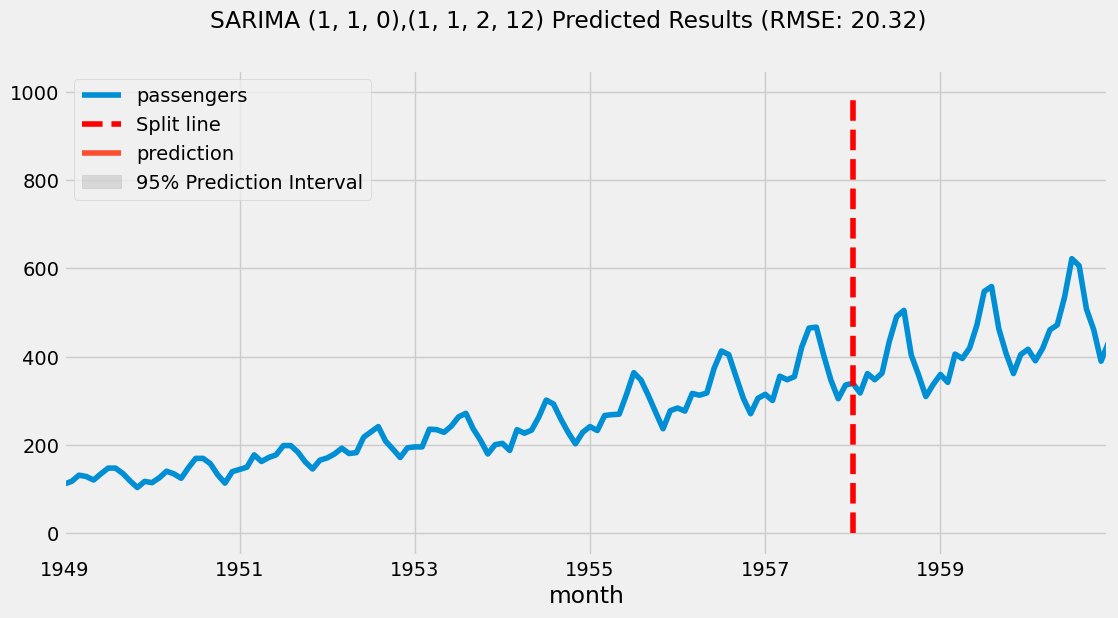

In [224]:
fig, ax =plt.subplots(figsize =(12, 6))

df.plot(ax=ax)

ax.vlines('01-01-1958' , 0, 1000, linestyle = '--', color = 'r', label = 'Split line') ;

ax.plot(sa_pred_index, sa_pred_value, label = 'prediction')

ax.fill_between(sa_pred_index, sa_pred_lb, sa_pred_ub, color = 'k', alpha = 0.1, label = '95% Prediction Interval')

ax.legend(loc = 'upper left')

plt.suptitle(f'SARIMA {optimal[0][0][0]},{optimal[0][0][1]} Predicted Results (RMSE: {round(rmse,2)})')

plt.show()

In [ ]:
### Diagnoisi check: Auto ARIMA

In [231]:
auto_arima_model = auto_arima(train, start_p=1, start_q=1,
                              max_p=3, max_q=3, m=12, seasonal=True,
                              d=1, D=1, max_P=3, max_Q=3,
                              Trace=True, error_action='ignore',
                              suppress_warning=True,
                              stepwise=False)

In [232]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  108
Model:             SARIMAX(0, 1, 3)x(0, 1, [], 12)   Log Likelihood                -346.643
Date:                             Wed, 01 Mar 2023   AIC                            701.286
Time:                                     23:35:01   BIC                            711.501
Sample:                                 01-01-1949   HQIC                           705.414
                                      - 12-01-1957                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2753      0.101     -2.733      0.006      -0.473      -0.078
ma.L2          0.0964      0.113      0.853      0.394      -0.125       0.318
ma.L3         -0.3059      0.111     -2.757      0.006      -0.523      -0.088
sigma2        86.1406     13.339      6.458      0.000      59.996     112.285
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.50
Prob(Q):                              0.89   Prob(JB):                         0.29
Heteroskedasticity (H):               1.04   Skew:                             0.37
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
## Forecast : Auto ARIMA

In [234]:
auto_pred = auto_arima_model.predict(len(test), return_conf_int = True)
auto_pred_value = auto_pred[0]
auto_pred_ub = auto_pred[1][:,0]
auto_pred_lb = auto_pred[1][:,1]
auto_pred_index = list(test.index)

rmse = sqrt(mean_squared_error(test, auto_pred_value))

print(rmse)

23.5107381467589


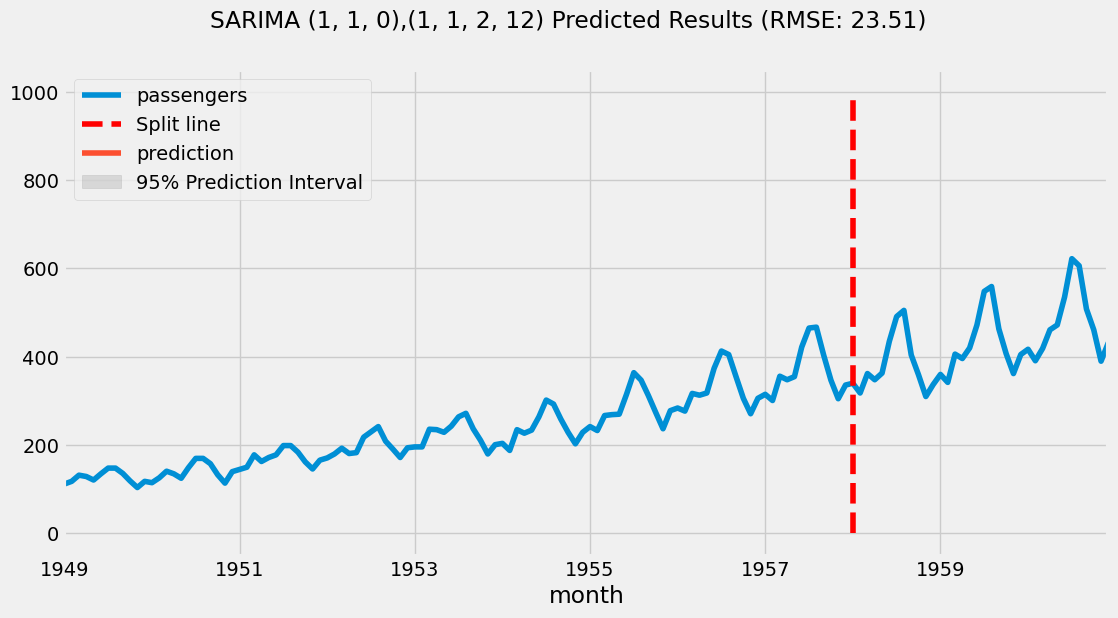

In [235]:
fig, ax =plt.subplots(figsize =(12, 6))

df.plot(ax=ax)

ax.vlines('01-01-1958' , 0, 1000, linestyle = '--', color = 'r', label = 'Split line') ;

ax.plot(sa_pred_index, sa_pred_value, label = 'prediction')

ax.fill_between(auto_pred_index, auto_pred_lb, auto_pred_ub, color = 'k', alpha = 0.1, label = '95% Prediction Interval')

ax.legend(loc = 'upper left')

plt.suptitle(f'SARIMA {optimal[0][0][0]},{optimal[0][0][1]} Predicted Results (RMSE: {round(rmse,2)})')

plt.show()

In [236]:
git init

SyntaxError: invalid syntax (2830201818.py, line 1)